# Model to substitute bottomPlateHeaterEnable with outsideTemperature
Multiple months of Historical data does not contain the hp1.bottomPlateHeaterEnable or hp2.bottomPlateHeaterEnable flag.  
This document aims to research the possible substitution of this parameter with hp1.outsideTemperature or hp2.outsideTemperature.  
  
The bottomPlateheaterEnable is:
- always off when powerInput = 0 or outsideTemperature > 7
- When powerInput > 0
    - always on when outsideTemperature <= 4 degC
    - partly on when 4 degC < outsideTemperature < 7 degC (for this part, multiple formulas will be fit to determine the best way to model this behaviour)

Open questions:
- For temperatures below 4 degrees, there still seems to be a percentage of heaters which is not one

In [51]:

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import math
import time

from sklearn.metrics import mean_squared_error


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from sklearn.mixture import GaussianMixture
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

from scipy.optimize import curve_fit


In [52]:
# load csv files from live data data archive to estimate model
cics = [
        'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6', 
        'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c',
        'CIC-7eede49c-42c2-5b41-94aa-481dad189abf', # 8kW
        'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea' # 8kW
        ]

path_live_data = os.path.join(os.path.split(os.getcwd())[0], 'data')
print(path_live_data)

for cic in cics:
        if cic == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6':
                X_train = pd.read_csv(os.path.join(path_live_data,f'{cic}-X_train-april.csv'))
                X_test = pd.read_csv(os.path.join(path_live_data,f'{cic}-X_test-april.csv'))
        else:
                X_train = pd.concat([X_train, pd.read_csv(os.path.join(path_live_data, f'{cic}-X_train-april.csv'))], ignore_index=True)
                X_test = pd.concat([X_test, pd.read_csv(os.path.join(path_live_data, f'{cic}-X_test-april.csv'))], ignore_index=True)

# combine train and test sets
X_total = pd.concat([X_train, X_test], ignore_index=True)

/Users/noutneijmeijer/Documents/quatt_data_analysis/power-energy-calculations/data


In [65]:
# set new X and y to train model filtered on powerinput> 0  and 4 < Toutside < 7 
X_total_filtered = X_total[(X_total['qc.hp1PowerInput']>0) & 
                           (X_total['hp1.temperatureOutside']<7)  &
                           (X_total['hp1.temperatureOutside'] >= 4)]

X = X_total_filtered['hp1.temperatureOutside']
y = X_total_filtered['hp1.bottomPlateHeaterEnable']


# create new train test split of data but now randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
X_grid = np.arange(X.min().round(1), X.max().round(1), 0.1)

### Comparing different models based on outside temparature

In [67]:
# fit logistic regressor
lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

y_pred_lr = lr.predict_proba(X_test.values.reshape(-1,1))[:,1]
print(f'Logistic regressor RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False)}')

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic regressor RMSE: 0.3487753291394497


In [80]:
# fit specific curve
def func_1(x, a, b, c):
    return 1 / (a + b*(x-c))

popt = curve_fit(func_1, X_train, y_train)[0]

print(*popt)

st = time.time()
stp = time.process_time()
y_pred_1 = func_1(X_test, *popt)
et = time.time()
etp = time.process_time()
print(f'Curve fit time: {et-st}')
print(f'Curve fit process time: {etp-stp}')
print(f'Curve fit RMSE: {mean_squared_error(y_test, y_pred_1)}')


0.31530397864623305 4.416233732189494 3.796331812113364
Curve fit time: 0.0007469654083251953
Curve fit process time: 0.0007669999999961874
Curve fit RMSE: 0.1196092904804333


In [79]:
# fit random forest regressor
rfr = RandomForestRegressor(n_estimators=20, random_state=42, oob_score=True, max_depth=5)
rfr.fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

# st = time.time()
# stp = time.process_time()
y_pred_rfr = rfr.predict(X_test.values.reshape(-1,1))
# et = time.time()
# etp = time.process_time()
# print(f'Curve fit time: {et-st}')
# print(f'Curve fit process time: {etp-stp}')
print(f'RandomForestRegressor RMSE: {mean_squared_error(y_test, y_pred_rfr)}')


/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_63592/2734518726.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))


RandomForestRegressor RMSE: 0.11607636537051648


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [70]:
# fit gradient boosting regressor
gbr = GradientBoostingRegressor(n_estimators=15, random_state=42)
gbr.fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

y_pred_grr = gbr.predict(X_test.values.reshape(-1,1))
print(f'GradientBoostingRegressor RMSE: {mean_squared_error(y_test, y_pred_grr, squared=False)}')

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor RMSE: 0.3419562300926637


In [71]:
# This model was taken out because it keeps crashing the kernel
# fit gaussian process regressor
# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
# gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
# gpr.fit(X_test.values.reshape(-1,1), y_test.values.reshape(-1,1))

# y_pred_gpr = gpr.predict(X_test.values.reshape(-1,1))
# print(f'GaussianProcessRegressor RMSE: {mean_squared_error(y_test, y_pred_gpr, squared=False)}')

In [72]:
# This model was taken out because it is too slow
# fit SVR
# svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# svr.fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

# y_pred_svr = svr.predict(X_test.values.reshape(-1,1))
# print(f'SVR RMSE: {mean_squared_error(y_test, y_pred_svr, squared=False)}')

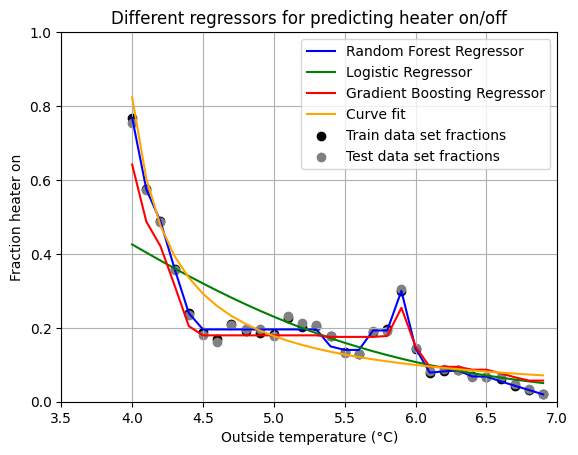

In [73]:
# plot results
count_heater_on_train = X_train[y_train==1].groupby(X_train.round(1)).count()
count_heater_off_train = X_train[y_train==0].groupby(X_train.round(1)).count()
frac_heater_on_train = count_heater_on_train/(count_heater_on_train + count_heater_off_train)

count_heater_on_test = X_test[y_test==1].groupby(X_test.round(1)).count()
count_heater_off_test = X_test[y_test==0].groupby(X_test.round(1)).count()
frac_heater_on_test = count_heater_on_test/(count_heater_on_test + count_heater_off_test)

plt.plot(X_grid, rfr.predict(X_grid.reshape(-1,1)), color='blue', label='Random Forest Regressor')
plt.plot(X_grid, lr.predict_proba(X_grid.reshape(-1,1))[:,1], color='green', label='Logistic Regressor')
plt.plot(X_grid, gbr.predict(X_grid.reshape(-1,1)), color='red', label='Gradient Boosting Regressor')
plt.plot(X_grid, func_1(X_grid, *popt), color='orange', label='Curve fit')
plt.scatter(frac_heater_on_train.index, frac_heater_on_train.values, color='black', label='Train data set fractions')
plt.scatter(frac_heater_on_test.index, frac_heater_on_test.values, color='grey', label='Test data set fractions')
plt.title('Different regressors for predicting heater on/off')
plt.xlabel('Outside temperature (°C)')
plt.ylabel('Fraction heater on')
plt.legend()
plt.grid()
plt.xlim(3.5,7)
plt.ylim(0,1)
plt.show()

<Axes: >

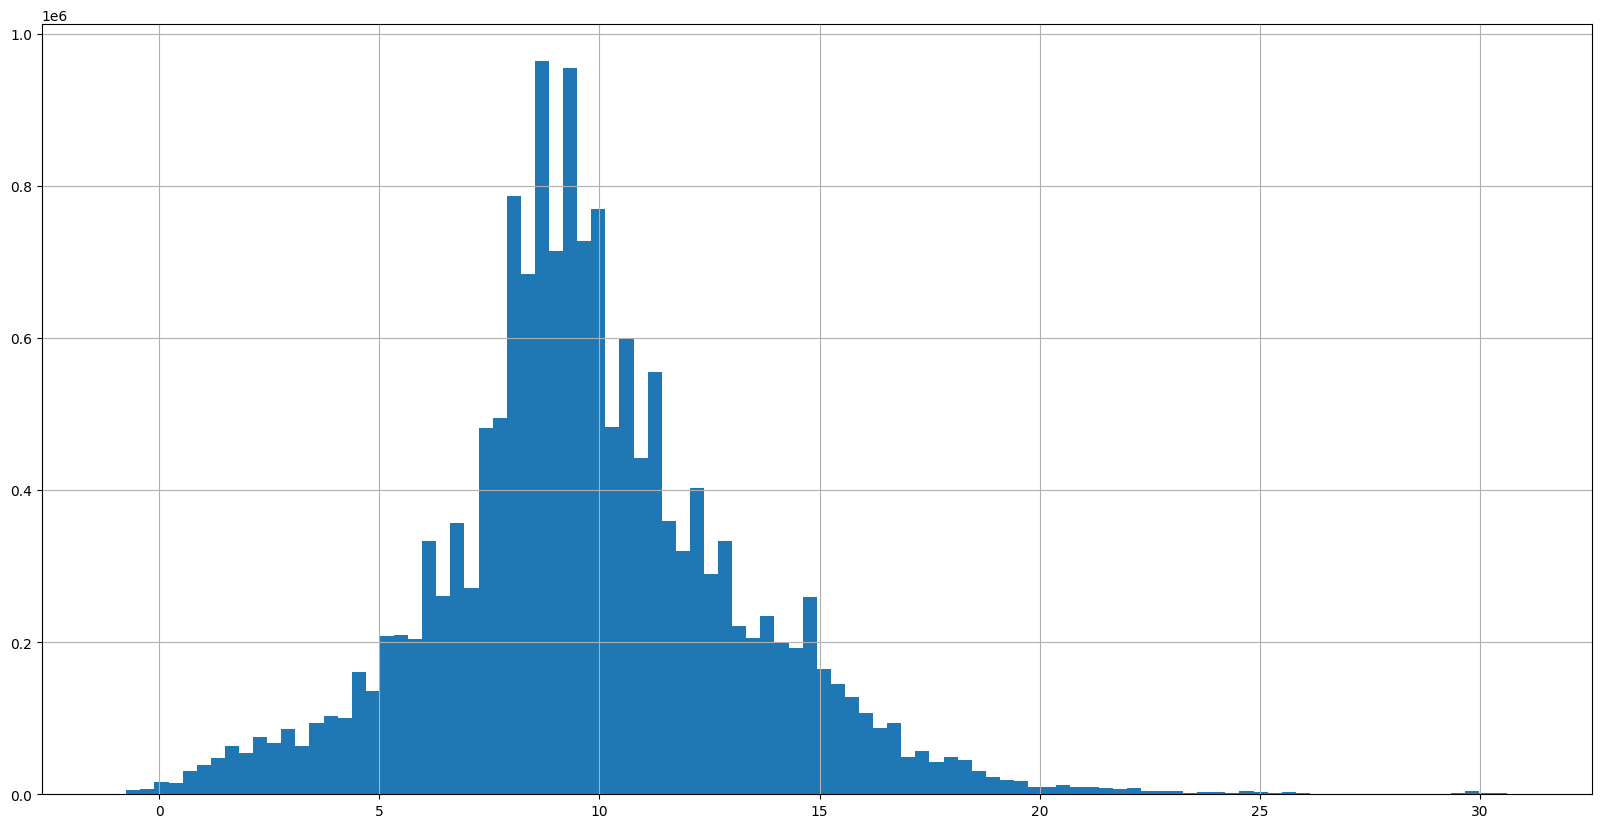

In [77]:
X_total['hp1.temperatureOutside'].hist(bins=100,figsize=[20,10])

Cluster 1 std: [[2.20168974]]
Cluster 2 std: [[2.6957615]]
Gaussian Mixture Model RMSE: 0.21839857545704316


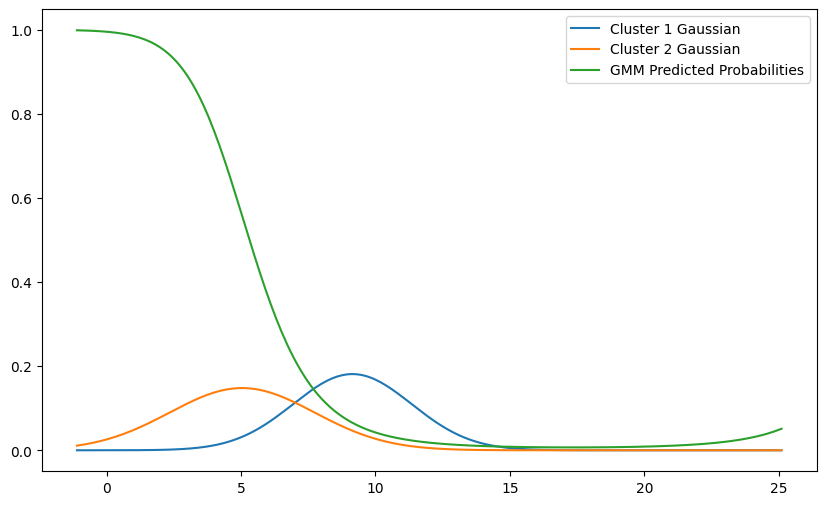

In [157]:
# print standard deviations of each cluster
print(f'Cluster 1 std: {np.sqrt(gmm.covariances_[0])}')
print(f'Cluster 2 std: {np.sqrt(gmm.covariances_[1])}')



# plot gaussian distributions of each cluster using cluster mean and std
# import norm
from scipy.stats import norm

plt.figure(figsize=(10,6))
# plt.hist(X_test[labels==0], bins=20, density=True, alpha=0.5, label='Cluster 1')
# plt.hist(X_test[labels==1], bins=20, density=True, alpha=0.5, label='Cluster 2')
plt.plot(X_grid, norm.pdf(X_grid.reshape(-1,1), gmm.means_[0], np.sqrt(gmm.covariances_[0])), label='Cluster 1 Gaussian')
plt.plot(X_grid, norm.pdf(X_grid.reshape(-1,1), gmm.means_[1], np.sqrt(gmm.covariances_[1])), label='Cluster 2 Gaussian')
# print predict proba of X_grid
plt.legend()
plt.show()


In [122]:
X_train.values.reshape(-1,1)

array([[ 1.01],
       [-0.61],
       [10.2 ],
       ...,
       [ 6.46],
       [10.84],
       [10.57]])

In [110]:
TEMPERATURES = np.linspace(4, 6.9, 30)

def fit_model(func, X, y):
    popt, pcov = curve_fit(func, X, y)
    
    rmse = get_rmse(func, X, y, popt)
    print(f'train rmse: {rmse}')

    predictor = func(TEMPERATURES, *popt).tolist()
    plot_bar_charts(X, y, predictor)
    return popt

def test_model(func, X, y, popt):
    rmse = get_rmse(func, X, y, popt)
    print(f'train rmse: {rmse}')

    predictor = func(TEMPERATURES, *popt).tolist()
    plot_bar_charts(X, y, predictor)

def get_rmse(func, X, y, popt):
    y_pred = func(X, *popt)
    square_errors = (y_pred-y)**2
    mean_square_error = np.mean(square_errors)
    return math.sqrt(mean_square_error)

# plot training data set
def plot_bar_charts(X, y, pred):
    count_heater_on = X[y==1].groupby(X.round(1)).count()
    count_heater_off = X[y==0].groupby(X.round(1)).count()

    frac_heater_on = count_heater_on/(count_heater_on + count_heater_off)
    frac_heater_off = count_heater_off/(count_heater_on + count_heater_off)

    plt.figure(figsize=(10,10))
    plt.bar(TEMPERATURES, frac_heater_on.values, label='heater on', width=0.1)
    plt.bar(TEMPERATURES, frac_heater_off.values, bottom=frac_heater_on, label='heater off', width=0.1, color="orange")
    plt.plot(TEMPERATURES, pred, c='cyan')
    plt.xlabel('Outside temperature')
    plt.ylabel('Fraction of time')
    plt.title('Fraction of time heater is on/off for different outside temperatures')
    plt.xlim([4,6.9])
    plt.ylim([0,1])
    plt.legend()
    plt.show()

### Random Forest Regressor model

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_30692/2035947558.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))


train rmse: 0.3444751822618394


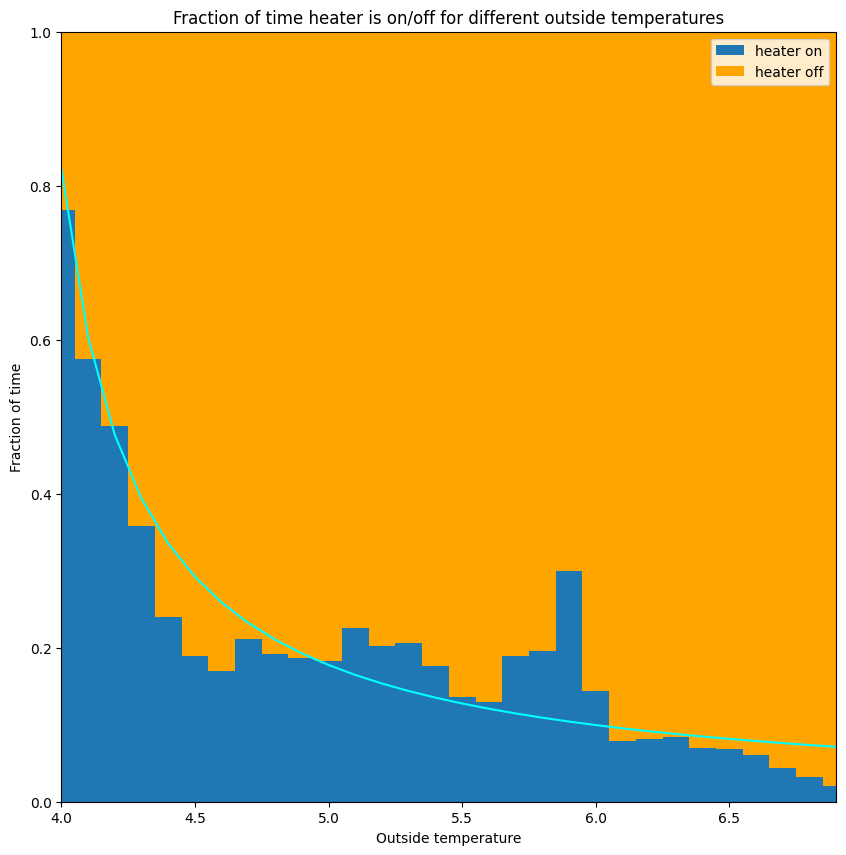

train rmse: 0.34584576111387183


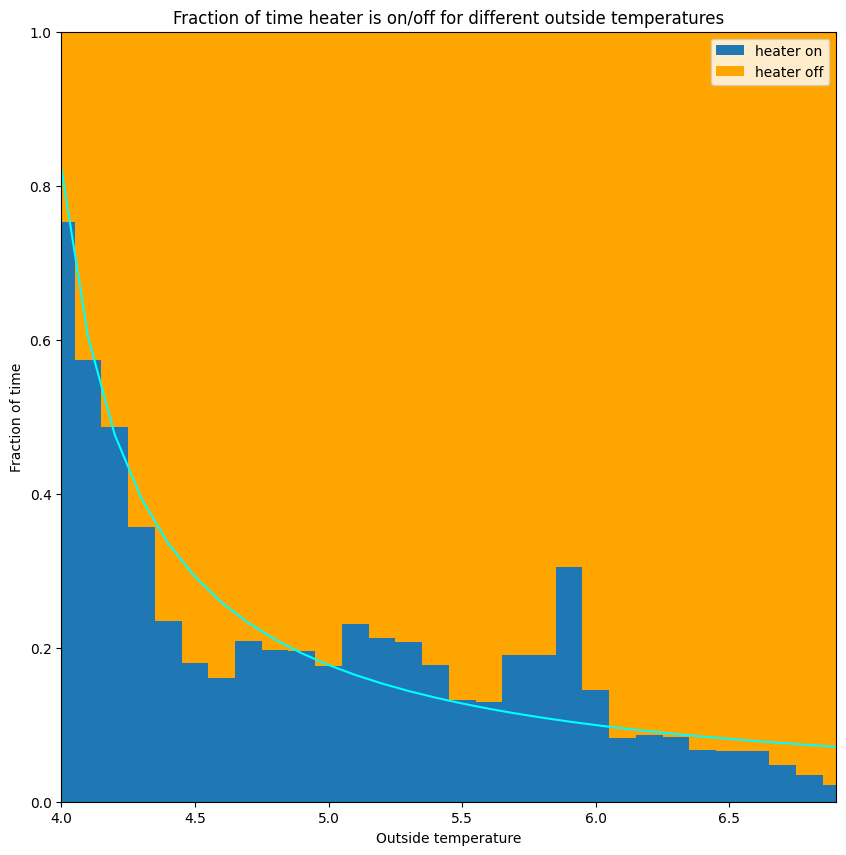

train rmse: 0.36178488761495053


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


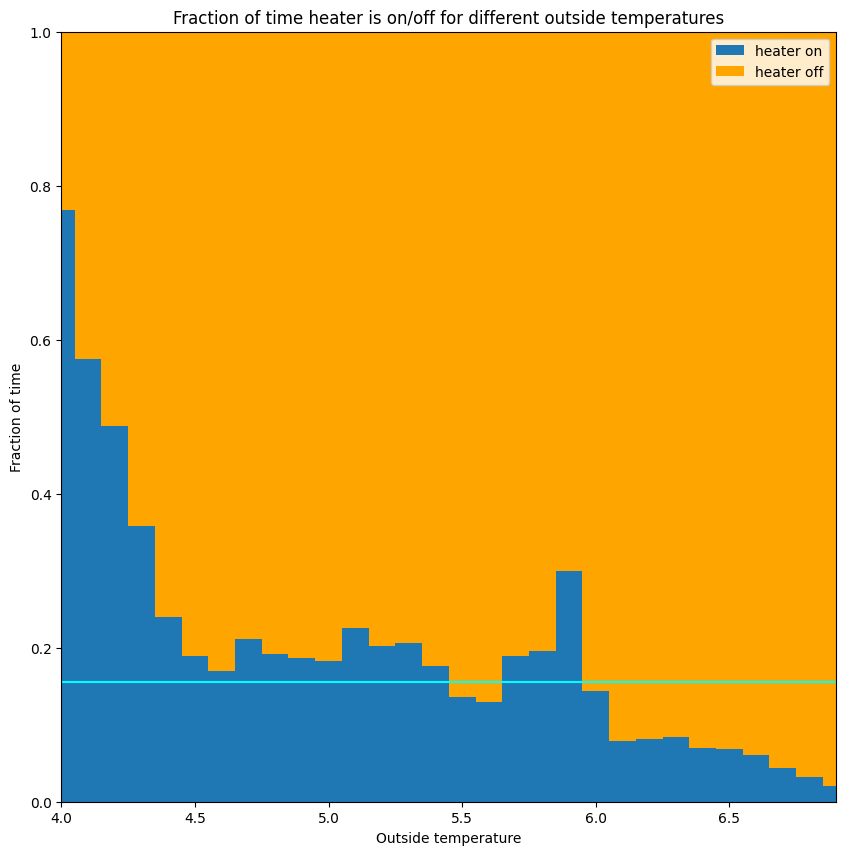

train rmse: 0.3620729791351021


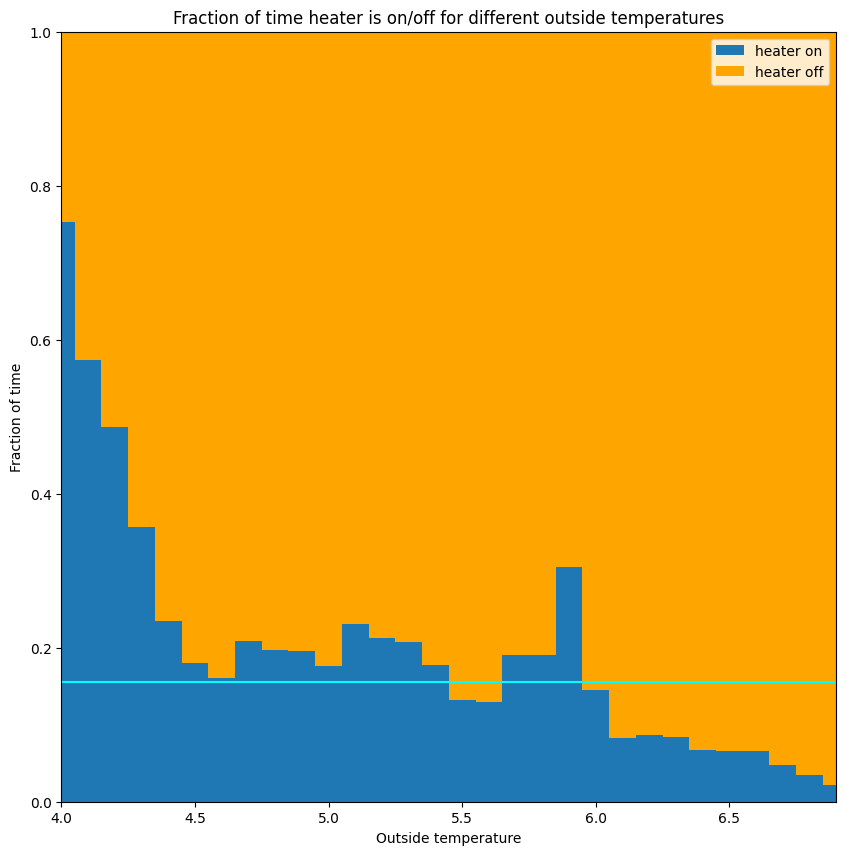

In [113]:

def func_1(x, a, b, c):
    return 1 / (a + b*(x-c))

popt = fit_model(func_1, X_train, y_train)
test_model(func_1, X_test, y_test, popt)


def func_2(x, a, b, c):
    return a * np.exp(-b * x) + c

popt = fit_model(func_2, X_train, y_train)
test_model(func_2, X_test, y_test, popt)

In [69]:
frac_heater_on

hp1.temperatureOutside
4.0    0.768162
4.1    0.575224
4.2    0.488523
4.3    0.358621
4.4    0.240188
4.5    0.188935
4.6    0.169937
4.7    0.210867
4.8    0.191503
4.9    0.186708
5.0    0.183074
5.1    0.226115
5.2    0.202807
5.3    0.205803
5.4    0.176492
5.5    0.135750
5.6    0.129849
5.7    0.189538
5.8    0.195899
5.9    0.299676
6.0    0.143803
6.1    0.078753
6.2    0.082041
6.3    0.084651
6.4    0.069442
6.5    0.068091
6.6    0.060806
6.7    0.043530
6.8    0.031737
6.9    0.019865
Name: hp1.temperatureOutside, dtype: float64

In [67]:
# X_total_filtered['hp1.temperatureOutsideRounded'] = X_total_filtered['hp1.temperatureOutside'].apply(lambda x: round(x,1))
# X_train['hp1.outsideTemperature'].apply(lambda x: len(X_total_filtered[(df['qc.hp1PowerInput']>0) &
#                                                                                         (df['hp1.temperatureOutsideRounded'] == x) &
#                                                                                         (df['hp1.bottomPlateHeaterEnable'] == 1)]))

df = pd.DataFrame({'temperature': X_train,
                   'bottomPlateHeaterEnable': y_train})
df['temperatureRounded'] = df['temperature'].apply(lambda x: round(x,1))
df[df['bottomPlateHeaterEnable']==1].value_counts()

temperature  bottomPlateHeaterEnable  temperatureRounded
5.92         1.0                      5.9                   8880
4.04         1.0                      4.0                   7243
4.13         1.0                      4.1                   5586
4.22         1.0                      4.2                   5491
4.31         1.0                      4.3                   4661
5.83         1.0                      5.8                   4615
5.74         1.0                      5.7                   4145
5.20         1.0                      5.2                   4132
5.02         1.0                      5.0                   3697
4.67         1.0                      4.7                   3582
5.29         1.0                      5.3                   3568
5.11         1.0                      5.1                   3550
4.40         1.0                      4.4                   3531
6.01         1.0                      6.0                   3388
4.84         1.0                 

hp1.temperatureOutside
4.0     2186
4.1     4125
4.2     5749
4.3     8336
4.4    11170
4.5    13561
4.6    13198
4.7    13405
4.8    26357
4.9    13926
5.0    16497
5.1    12150
5.2    16242
5.3    13769
5.4    13844
5.5    14592
5.6    33734
5.7    17724
5.8    18943
5.9    20752
6.0    20172
6.1    27256
6.2    26160
6.3    24189
6.4    28302
6.5    31889
6.6    60208
6.7    28674
6.8    33224
6.9    29357
Name: hp1.temperatureOutside, dtype: int64

<Axes: >

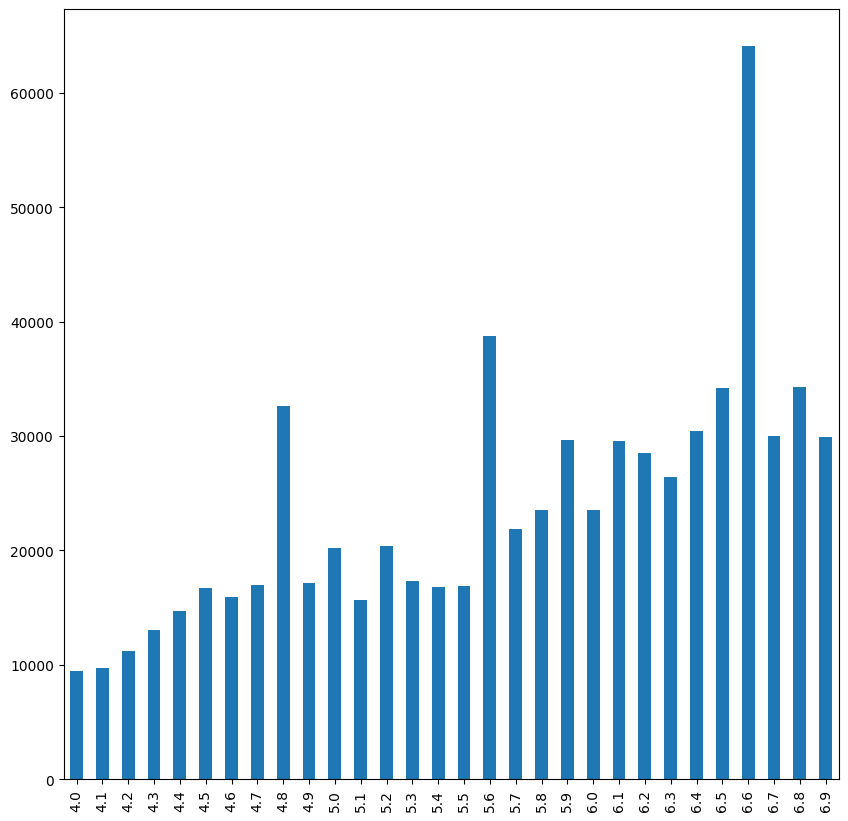

In [36]:
X_train.round(1).value_counts().sort_index().plot(kind='bar', figsize=(10,10))

In [ ]:
# make x and y dataframes for both testing and training
df_temperatureOutside = pd.concat([X_train['temperatureOutside'], X_test['temperatureOutside']], ignore_index=True)
df_bottomPlateHeaterEnable = pd.concat([X_train['bottomPlateHeaterEnable'], X_test['bottomPlateHeaterEnable']], ignore_index=True)

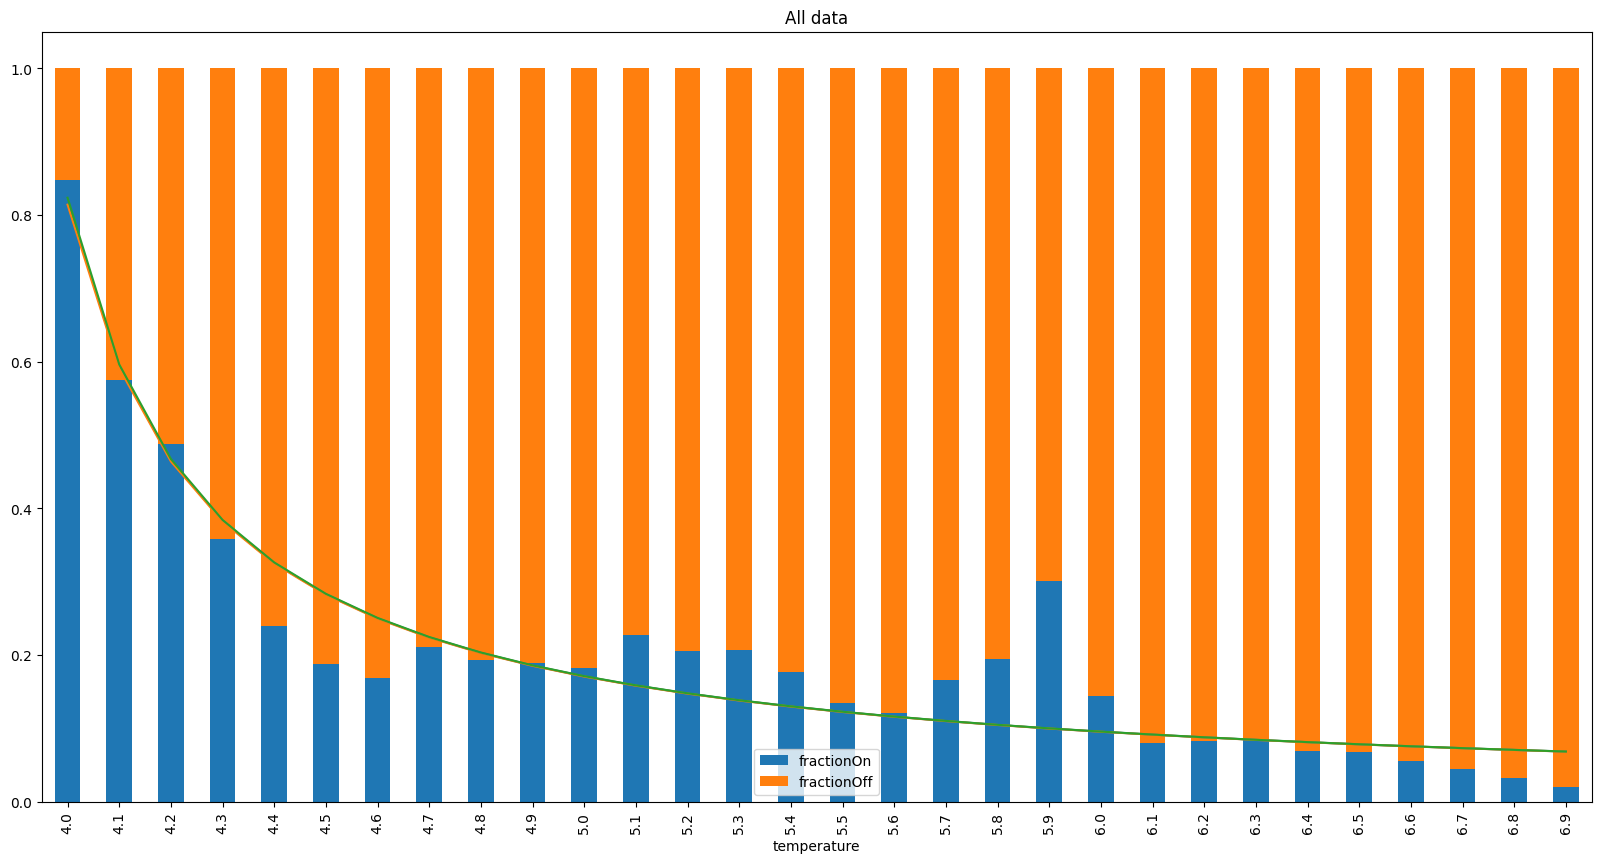

[4.09679457 4.63034307 4.62251133]
[4.39633769 4.63602296 4.68331436]
[4.41763587 4.63332574 4.6898328 ]


In [9]:
# fit curve for 4-7 degrees temperature interval for full data set
def fit_curve(df, func, min_temp=4, max_temp=7):
    temperatures = df[(df['qc.hp1PowerInput']>0) &
                       (df['hp1.temperatureOutside'] < max_temp) &
                       (df['hp1.temperatureOutside'] > min_temp)]['hp1.temperatureOutsideRounded'].sort_values().unique()
    df_counts = pd.DataFrame(temperatures, columns=['temperature'])
    df_counts['countHeatCoilOn'] = df_counts['temperature'].apply(lambda x: len(df[(df['qc.hp1PowerInput']>0) &
                                                                                        (df['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (df['hp1.bottomPlateHeaterEnable'] == 1)]))
    df_counts['countHeatCoilOff'] = df_counts['temperature'].apply(lambda x: len(df[(df['qc.hp1PowerInput']>0) &
                                                                                        (df['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (df['hp1.bottomPlateHeaterEnable'] == 0)]))
    df_counts['fractionOn'] = df_counts['countHeatCoilOn'] / (df_counts['countHeatCoilOn'] + df_counts['countHeatCoilOff'])
    popt, pcov = curve_fit(func, df_counts['temperature'], df_counts['fractionOn'])
    return popt

# set temperatures and curve fit also try: gaussian mixture model, random forest regression version, support vector regression
def func(x, a, b, c):
    return 1 / (a + b*(x-c))

X_total = pd.concat([X_train, X_test])
X_total['hp1.temperatureOutsideRounded'] = X_total['hp1.temperatureOutside'].apply(lambda x: round(x,1))

popt_total = fit_curve(X_total, func)

# random train test split and fit new curves
X_train_popt, X_test_popt = train_test_split(X_total, test_size=0.5, random_state=42) # search how to make sure that the split of data contains an equal amount of temperatures (4-7 degrees)
# use group shuffle split

popt_train = fit_curve(X_train_popt, func)
popt_test = fit_curve(X_test_popt, func)

# plot curves
temperatures = X_total[(X_total['qc.hp1PowerInput']>0) &
            (X_total['hp1.temperatureOutside'] < 7) &
            (X_total['hp1.temperatureOutside'] > 4)]['hp1.temperatureOutsideRounded'].sort_values().unique()
heatcoil_df = pd.DataFrame(temperatures, columns=['temperature'])
heatcoil_df['countHeatCoilOn'] = heatcoil_df['temperature'].apply(lambda x: len(X_total[(X_total['qc.hp1PowerInput']>0) &
                                                                                        (X_total['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_total['hp1.bottomPlateHeaterEnable'] == 1)]))
heatcoil_df['countHeatCoilOff'] = heatcoil_df['temperature'].apply(lambda x: len(X_total[(X_total['qc.hp1PowerInput']>0) &
                                                                                        (X_total['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_total['hp1.bottomPlateHeaterEnable'] == 0)]))
heatcoil_df['fractionOn'] = heatcoil_df['countHeatCoilOn'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])
heatcoil_df['fractionOff'] = heatcoil_df['countHeatCoilOff'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])
heatcoil_df.set_index('temperature', inplace=True)

ax4 = heatcoil_df[['fractionOn', 'fractionOff']].plot.bar(stacked=True, figsize=[20,10])
ax4.plot(10*(heatcoil_df.index-4), (1/(popt_total[0] + popt_total[1]*(heatcoil_df.index-popt_total[2]))).tolist())
ax4.plot(10*(heatcoil_df.index-4), (1/(popt_test[0] + popt_test[1]*(heatcoil_df.index-popt_test[2]))).tolist())
ax4.plot(10*(heatcoil_df.index-4), (1/(popt_train[0] + popt_train[1]*(heatcoil_df.index-popt_train[2]))).tolist())
plt.title('All data')
plt.show()
print(popt_train)
print(popt_test)
print(popt_total)

In [ ]:
# add temperatures to X data sets for validation
X_train['bottomPlateHeaterEnableCalc1'] = X_train.apply(lambda x: 1 if ((x['hp1.temperatureOutside'] <= 4) & (x['qc.hp1PowerInput'] > 0)) else 0, axis=1)
X_train['bottomPlateHeaterEnableCalc2'] = X_train.apply(lambda x: (1/(popt_total[0]+popt_total[1]*(x['hp1.temperatureOutside']-popt_total[2]))) 
                                                        if ((x['hp1.temperatureOutside'] < 7) & 
                                                            (x['qc.hp1PowerInput'] > 0) & 
                                                            (x['hp1.temperatureOutside'] > 4)) else 0, axis=1)
X_test['bottomPlateHeaterEnableCalc1'] = X_test.apply(lambda x: 1 if ((x['hp1.temperatureOutside'] <= 4) & (x['qc.hp1PowerInput'] > 0)) else 0, axis=1)
X_test['bottomPlateHeaterEnableCalc2'] = X_test.apply(lambda x: (1/(popt_total[0]+popt_total[1]*(x['hp1.temperatureOutside']-popt_total[2]))) 
                                                        if ((x['hp1.temperatureOutside'] < 7) & 
                                                            (x['qc.hp1PowerInput'] > 0) & 
                                                            (x['hp1.temperatureOutside'] > 4)) else 0, axis=1)

#### Exploring different curve fits for heatCoilEnable

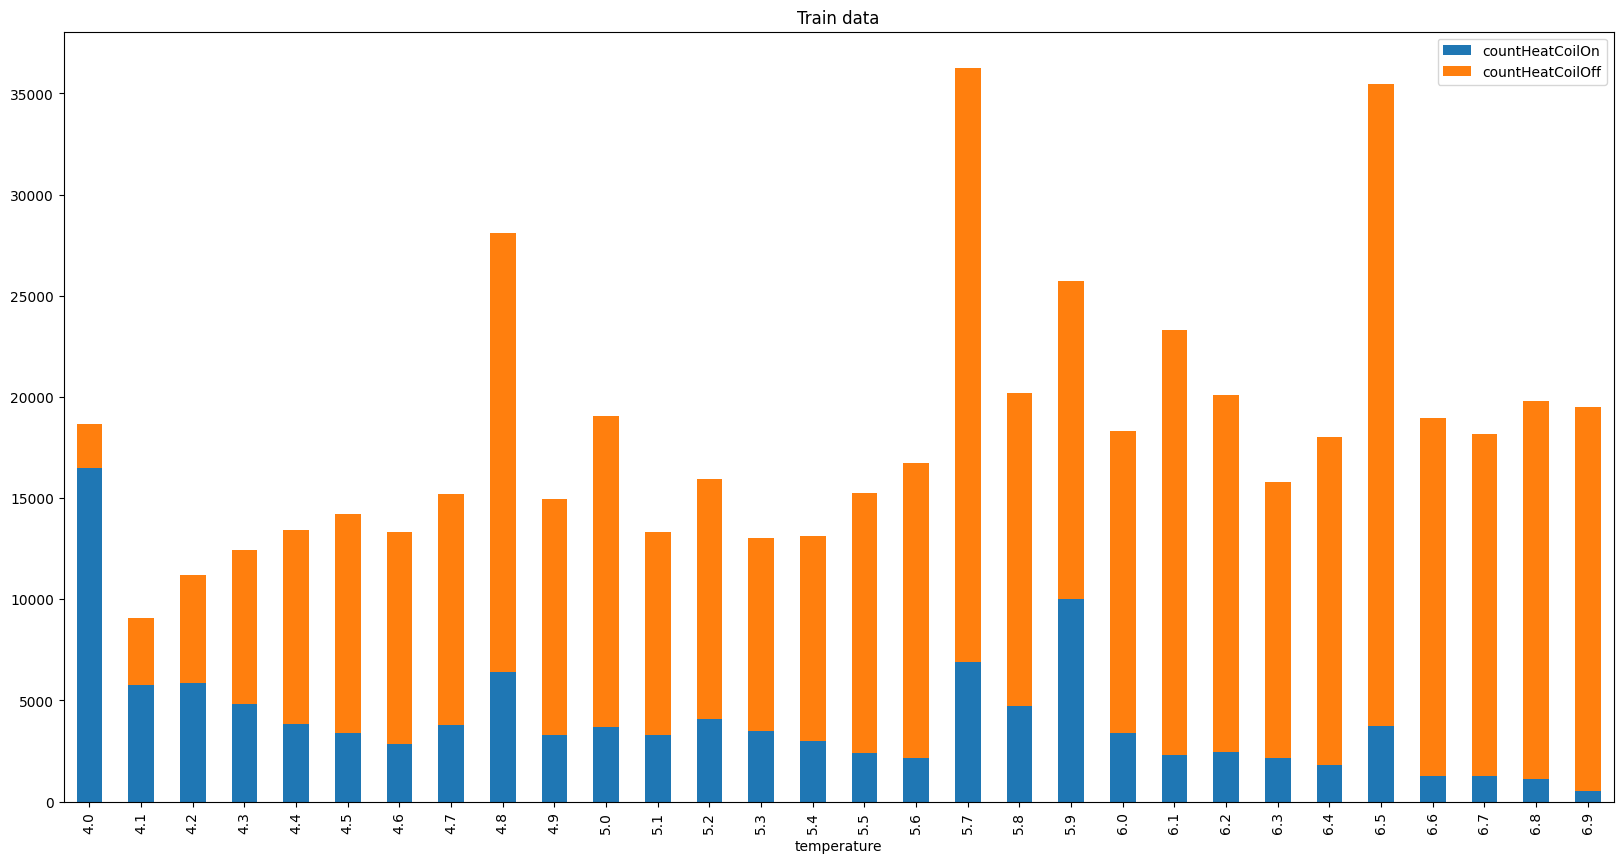

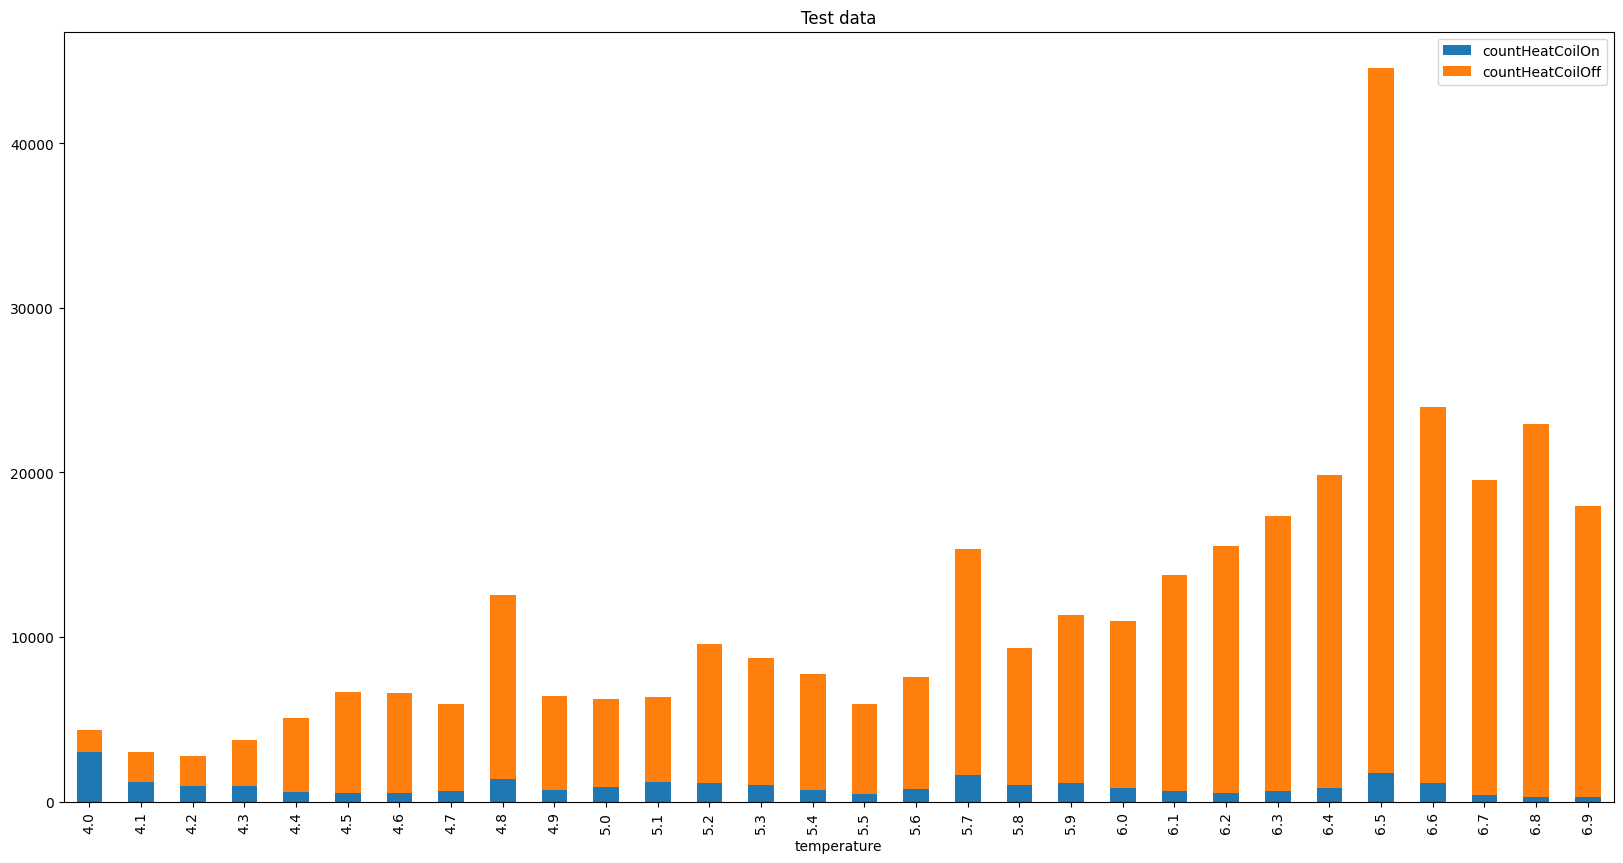

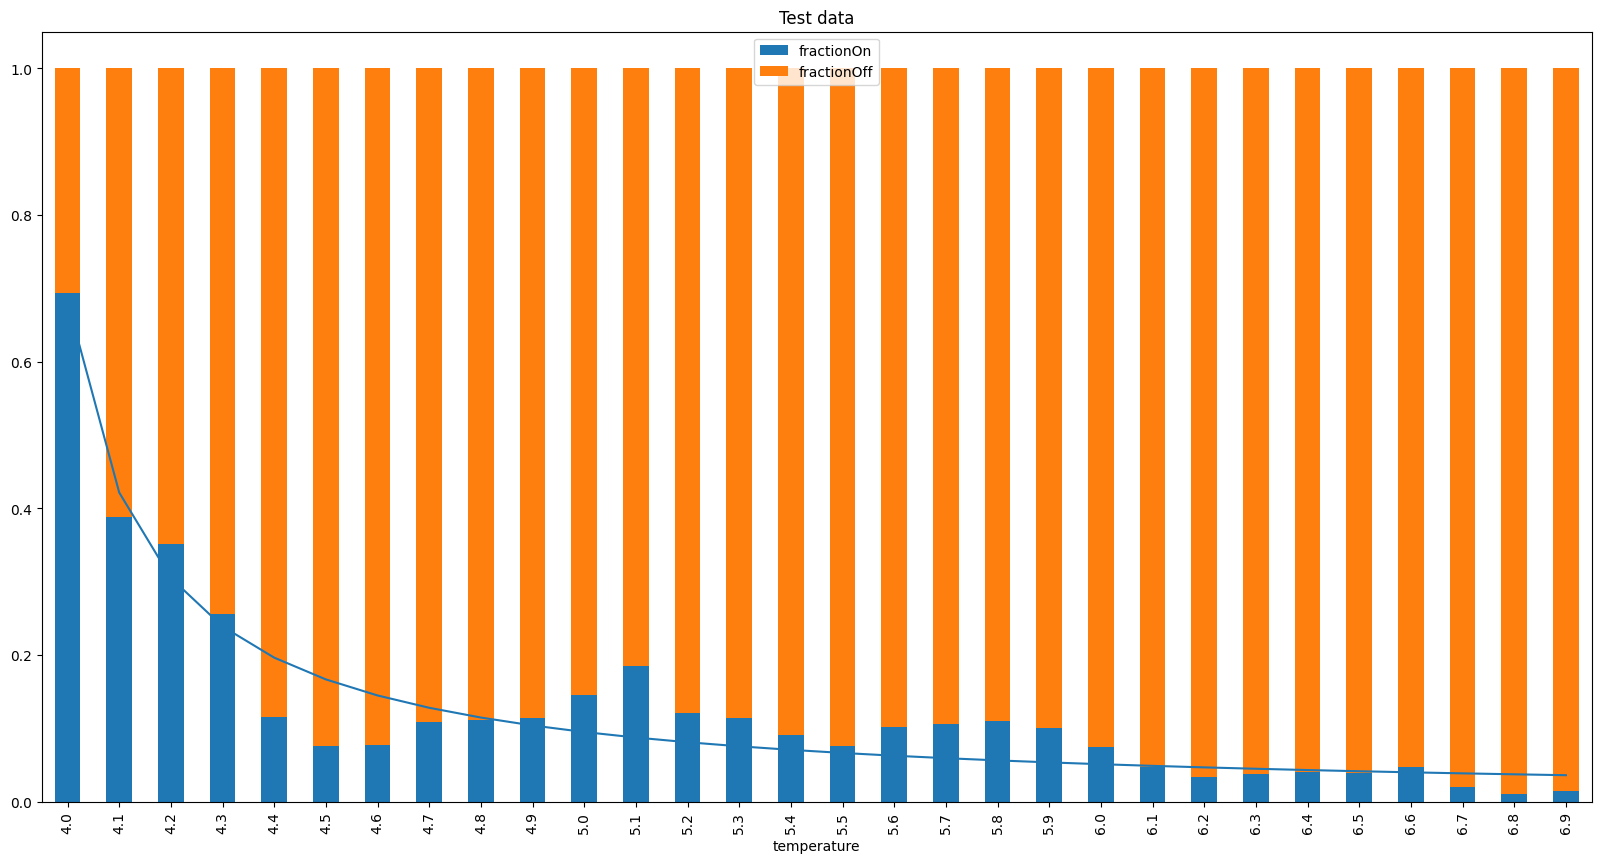

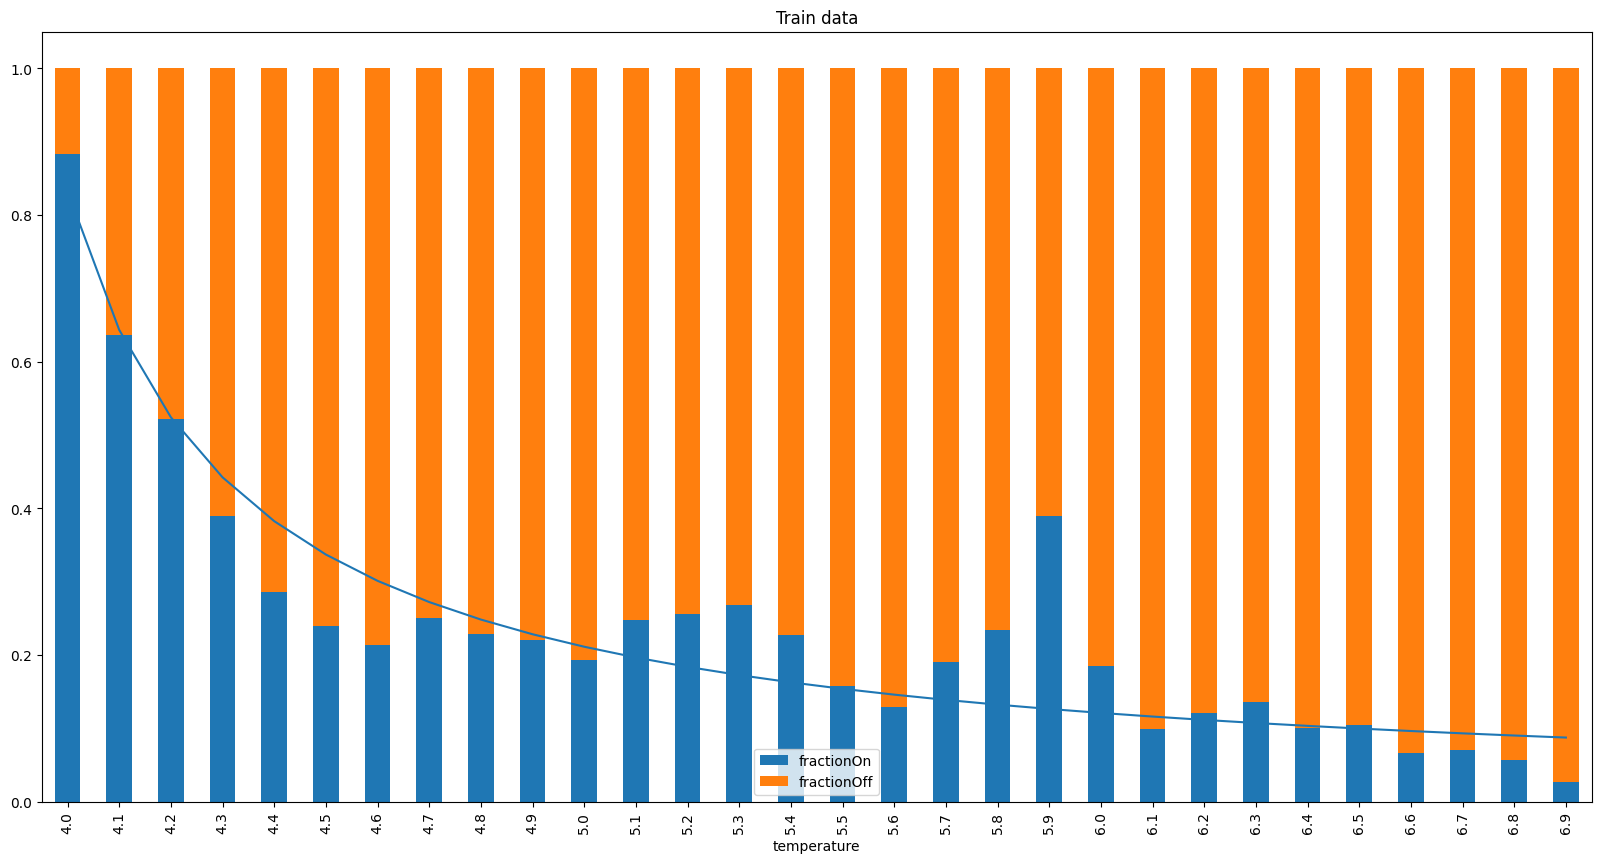

In [ ]:
# check how we can statically model heatCoil on based on outside temperature
X_train['hp1.temperatureOutsideRounded'] = X_train['hp1.temperatureOutside'].apply(lambda x: round(x,1))
X_test['hp1.temperatureOutsideRounded'] = X_test['hp1.temperatureOutside'].apply(lambda x: round(x,1))
temperatures = X_train[(X_train['qc.hp1PowerInput']>0) &
                       (X_train['hp1.temperatureOutside'] < 7) &
                       (X_train['hp1.temperatureOutside'] > 4)]['hp1.temperatureOutsideRounded'].sort_values().unique()

heatcoil_df_train = pd.DataFrame(temperatures, columns=['temperature'])
heatcoil_df_train['countHeatCoilOn'] = heatcoil_df_train['temperature'].apply(lambda x: len(X_train[(X_train['qc.hp1PowerInput']>0) &
                                                                                        (X_train['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_train['hp1.bottomPlateHeaterEnable'] == 1)]))
heatcoil_df_train['countHeatCoilOff'] = heatcoil_df_train['temperature'].apply(lambda x: len(X_train[(X_train['qc.hp1PowerInput']>0) &
                                                                                        (X_train['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_train['hp1.bottomPlateHeaterEnable'] == 0)]))
heatcoil_df_train['fractionOn'] = heatcoil_df_train['countHeatCoilOn'] / (heatcoil_df_train['countHeatCoilOn'] + heatcoil_df_train['countHeatCoilOff'])
heatcoil_df_train['fractionOff'] = heatcoil_df_train['countHeatCoilOff'] / (heatcoil_df_train['countHeatCoilOn'] + heatcoil_df_train['countHeatCoilOff'])
heatcoil_df_train.set_index('temperature', inplace=True)

heatcoil_df_test = pd.DataFrame(temperatures, columns=['temperature'])
heatcoil_df_test['countHeatCoilOn'] = heatcoil_df_test['temperature'].apply(lambda x: len(X_test[(X_test['qc.hp1PowerInput']>0) &
                                                                                        (X_test['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_test['hp1.bottomPlateHeaterEnable'] == 1)]))
heatcoil_df_test['countHeatCoilOff'] = heatcoil_df_test['temperature'].apply(lambda x: len(X_test[(X_test['qc.hp1PowerInput']>0) &
                                                                                        (X_test['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_test['hp1.bottomPlateHeaterEnable'] == 0)]))
heatcoil_df_test['fractionOn'] = heatcoil_df_test['countHeatCoilOn'] / (heatcoil_df_test['countHeatCoilOn'] + heatcoil_df_test['countHeatCoilOff'])
heatcoil_df_test['fractionOff'] = heatcoil_df_test['countHeatCoilOff'] / (heatcoil_df_test['countHeatCoilOn'] + heatcoil_df_test['countHeatCoilOff'])
heatcoil_df_test.set_index('temperature', inplace=True)

# create absolute and relative stacked bar plots


ax1 = heatcoil_df_train[['countHeatCoilOn', 'countHeatCoilOff']].plot.bar(stacked=True, figsize=[20,10])
plt.title('Train data')
plt.show()
ax3 = heatcoil_df_test[['countHeatCoilOn', 'countHeatCoilOff']].plot.bar(stacked=True, figsize=[20,10])
plt.title('Test data')
plt.show()

popt, pcov = curve_fit(func, heatcoil_df_test.index, heatcoil_df_test['fractionOn'])
ax4 = heatcoil_df_test[['fractionOn', 'fractionOff']].plot.bar(stacked=True, figsize=[20,10])
ax4.plot(10*(heatcoil_df_test.index-4), (1/(popt[0] + popt[1]*(heatcoil_df_test.index-popt[2]))).tolist())
plt.title('Test data')
plt.show()
popt, pcov = curve_fit(func, heatcoil_df_train.index, heatcoil_df_train['fractionOn'])
ax2 = heatcoil_df_train[['fractionOn', 'fractionOff']].plot.bar(stacked=True, figsize=[20,10])
ax2.plot(10*(heatcoil_df_train.index-4), (1/(popt[0] + popt[1]*(heatcoil_df_train.index-popt[2]))).tolist())
plt.title('Train data')
plt.show()





[-29.44887825   7.54302532  -0.03823821]


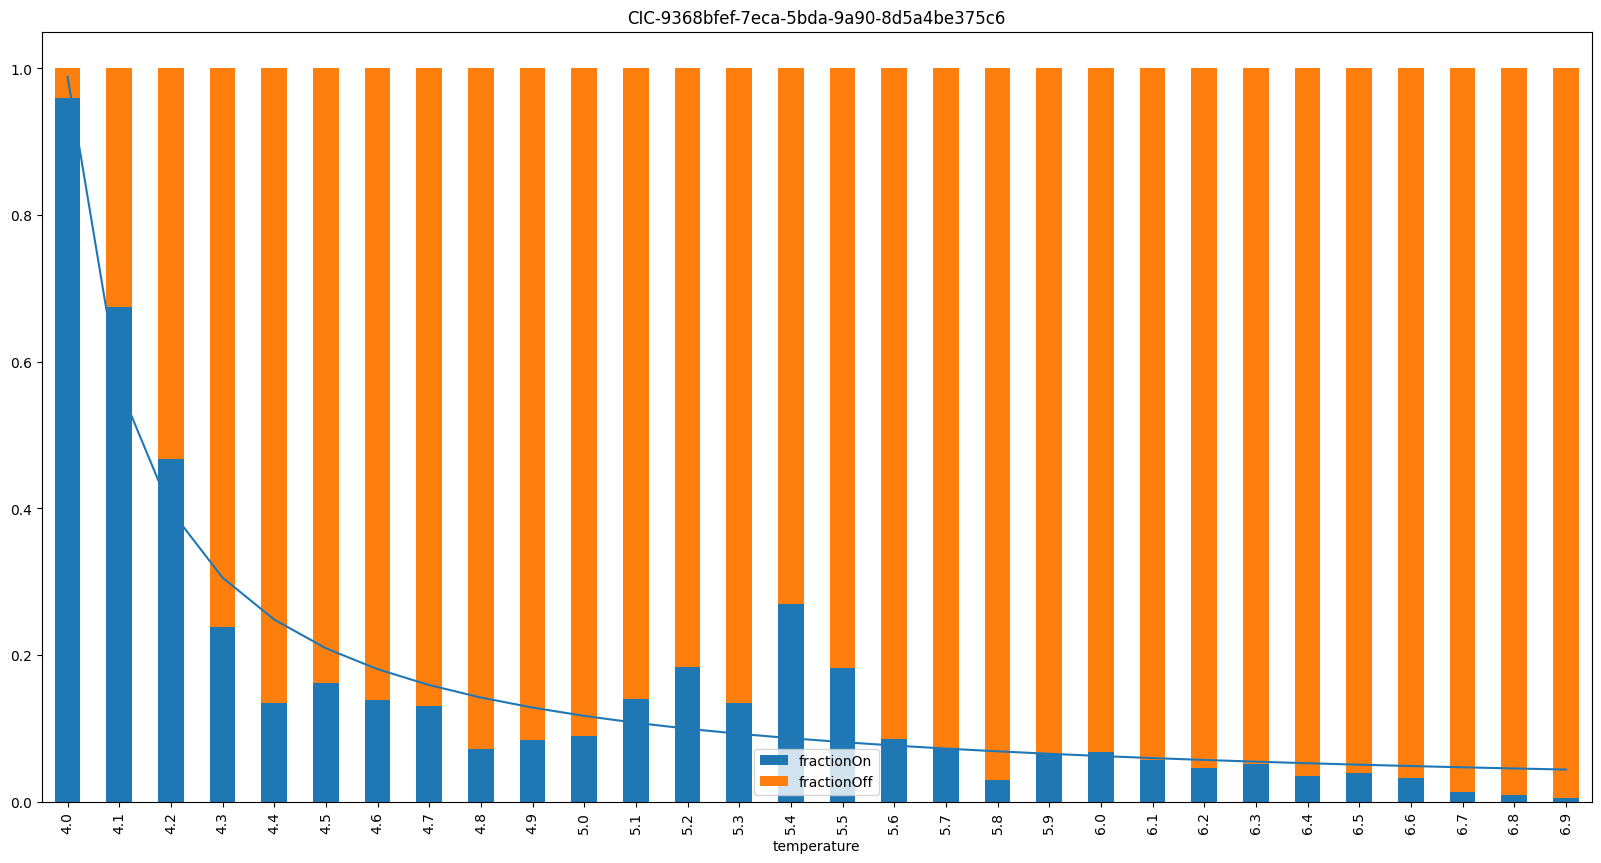

[-6.54432216  2.46484055  0.98974868]


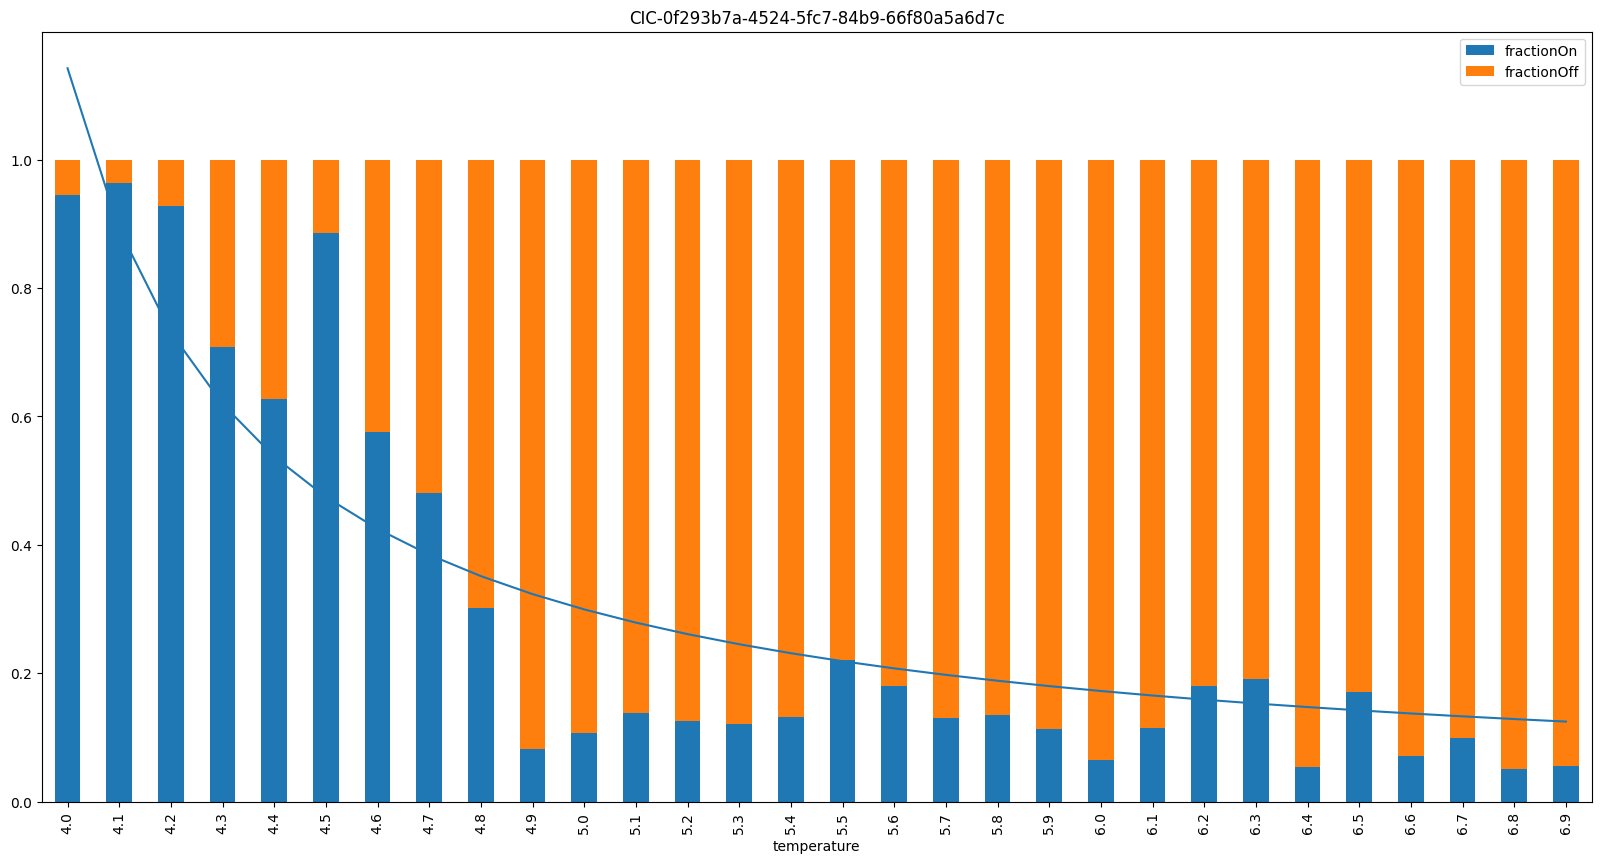

[0.41363317 1.16854368 2.75082684]


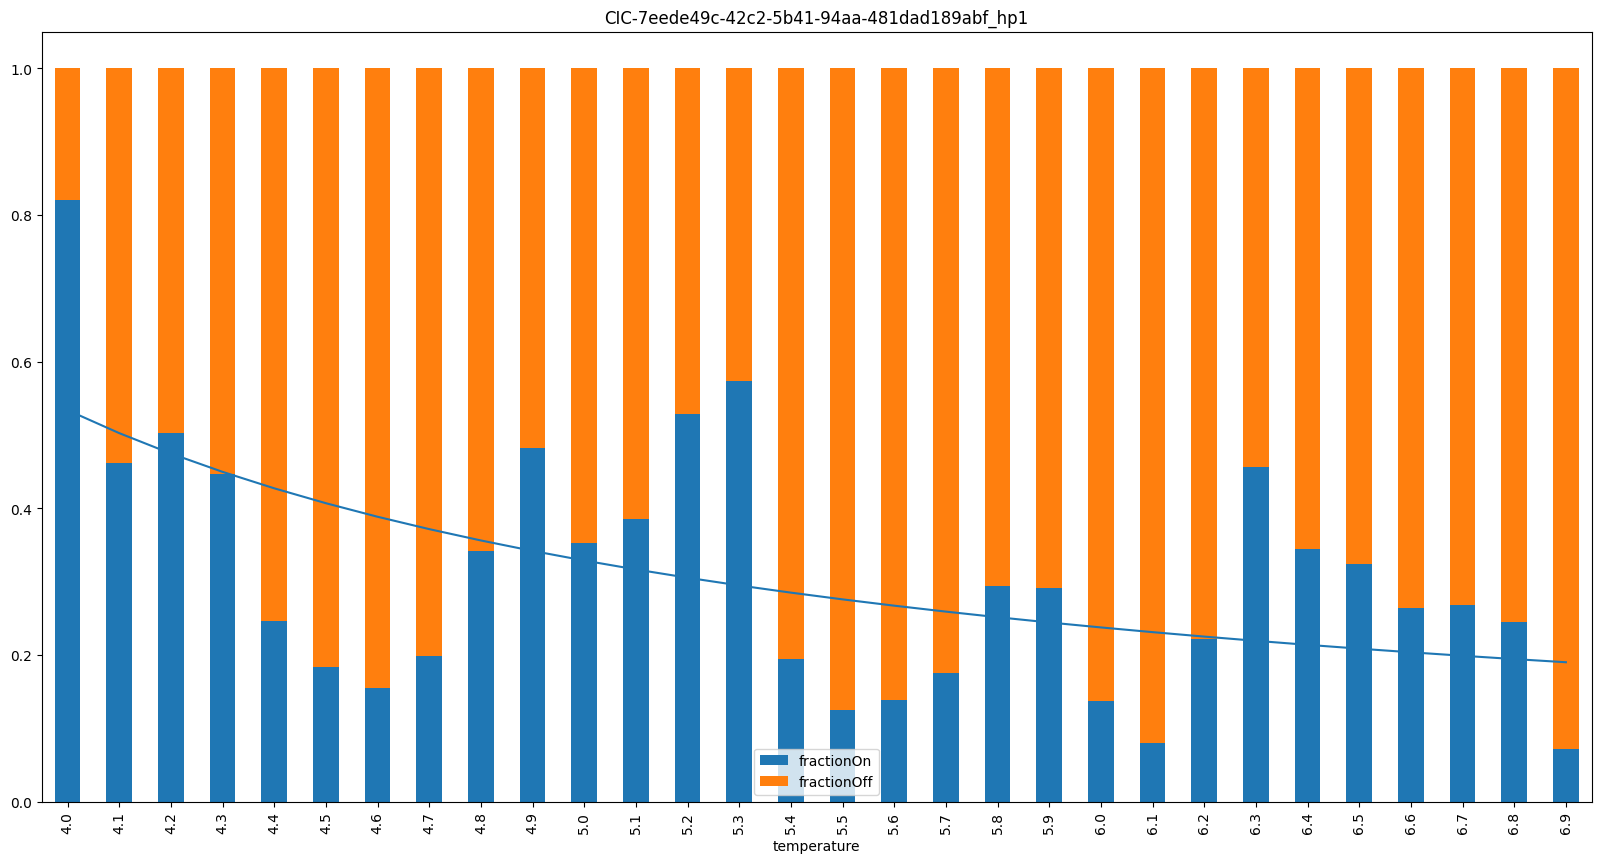

[11.60864281  0.67816353 18.63582095]


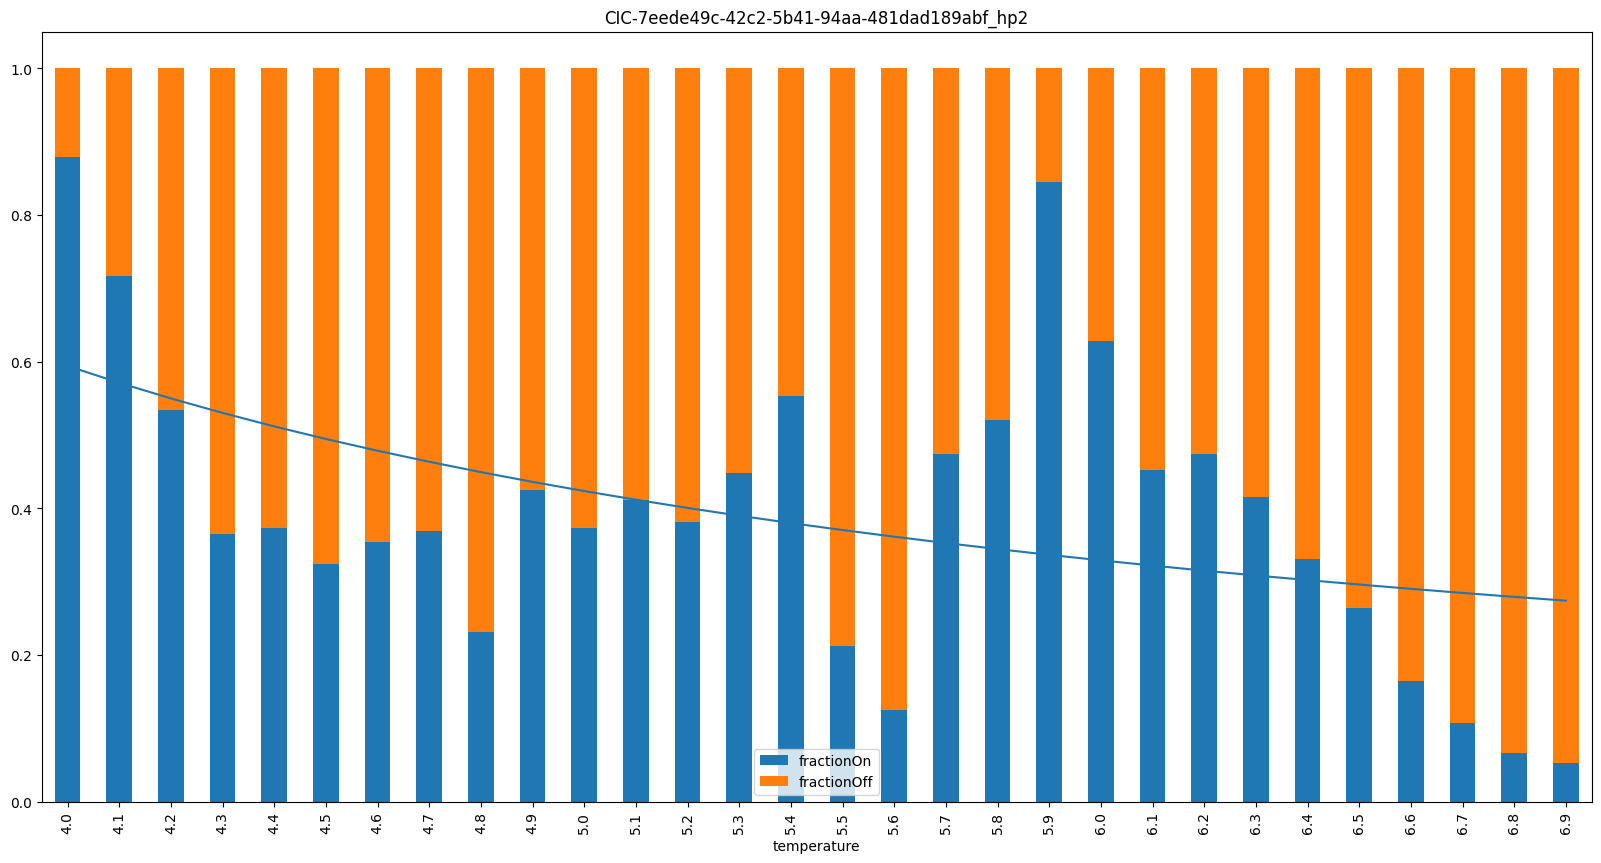

[9.70148334 5.01419571 5.71689536]


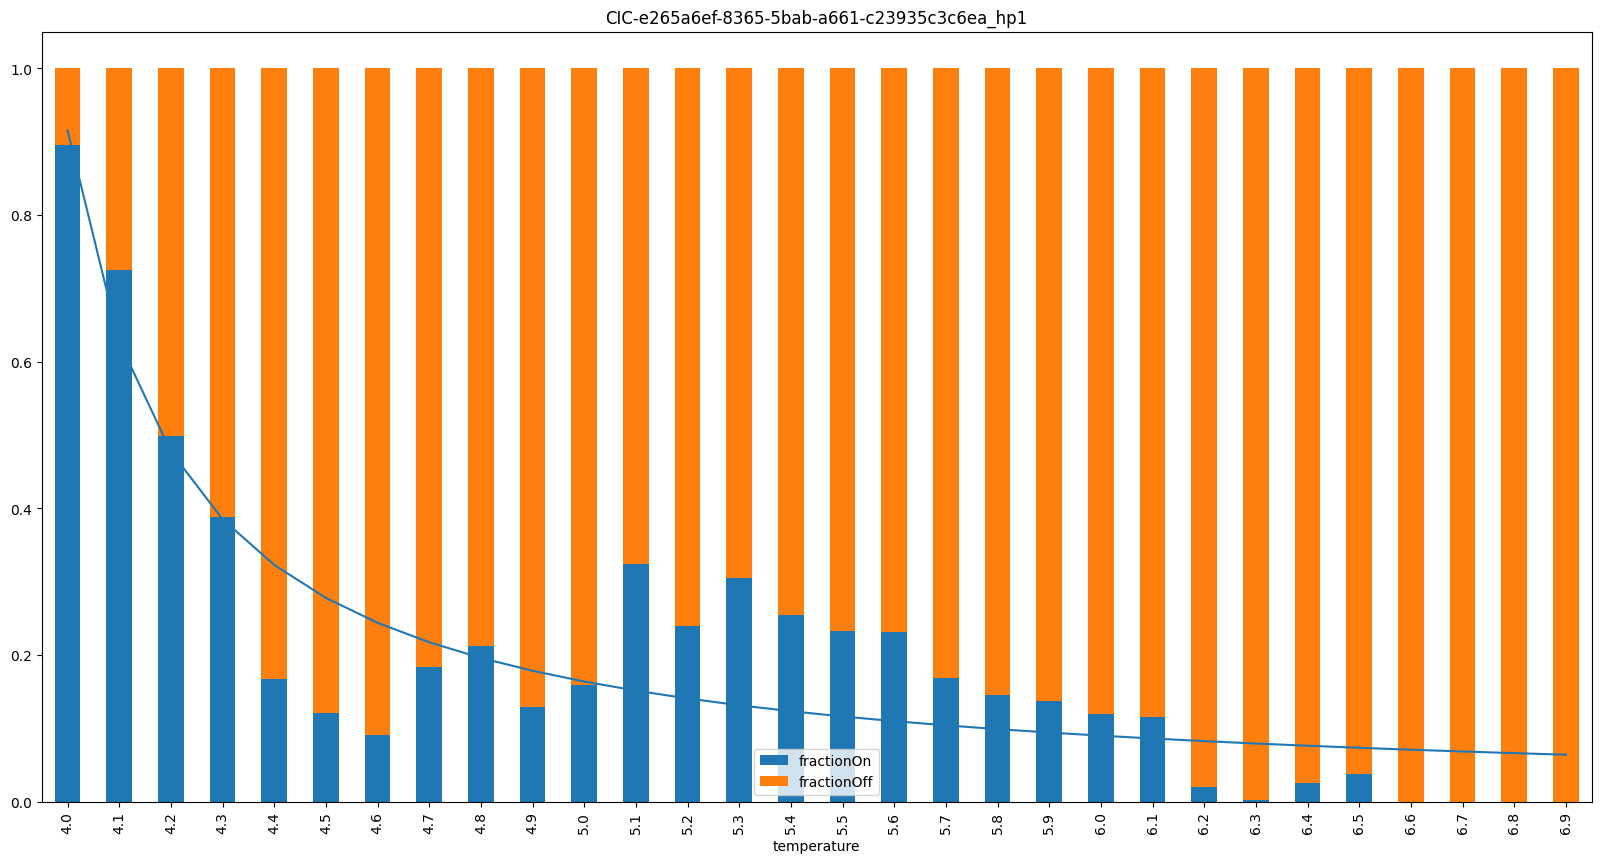

[ 5.4316412  10.40033601  4.38215777]


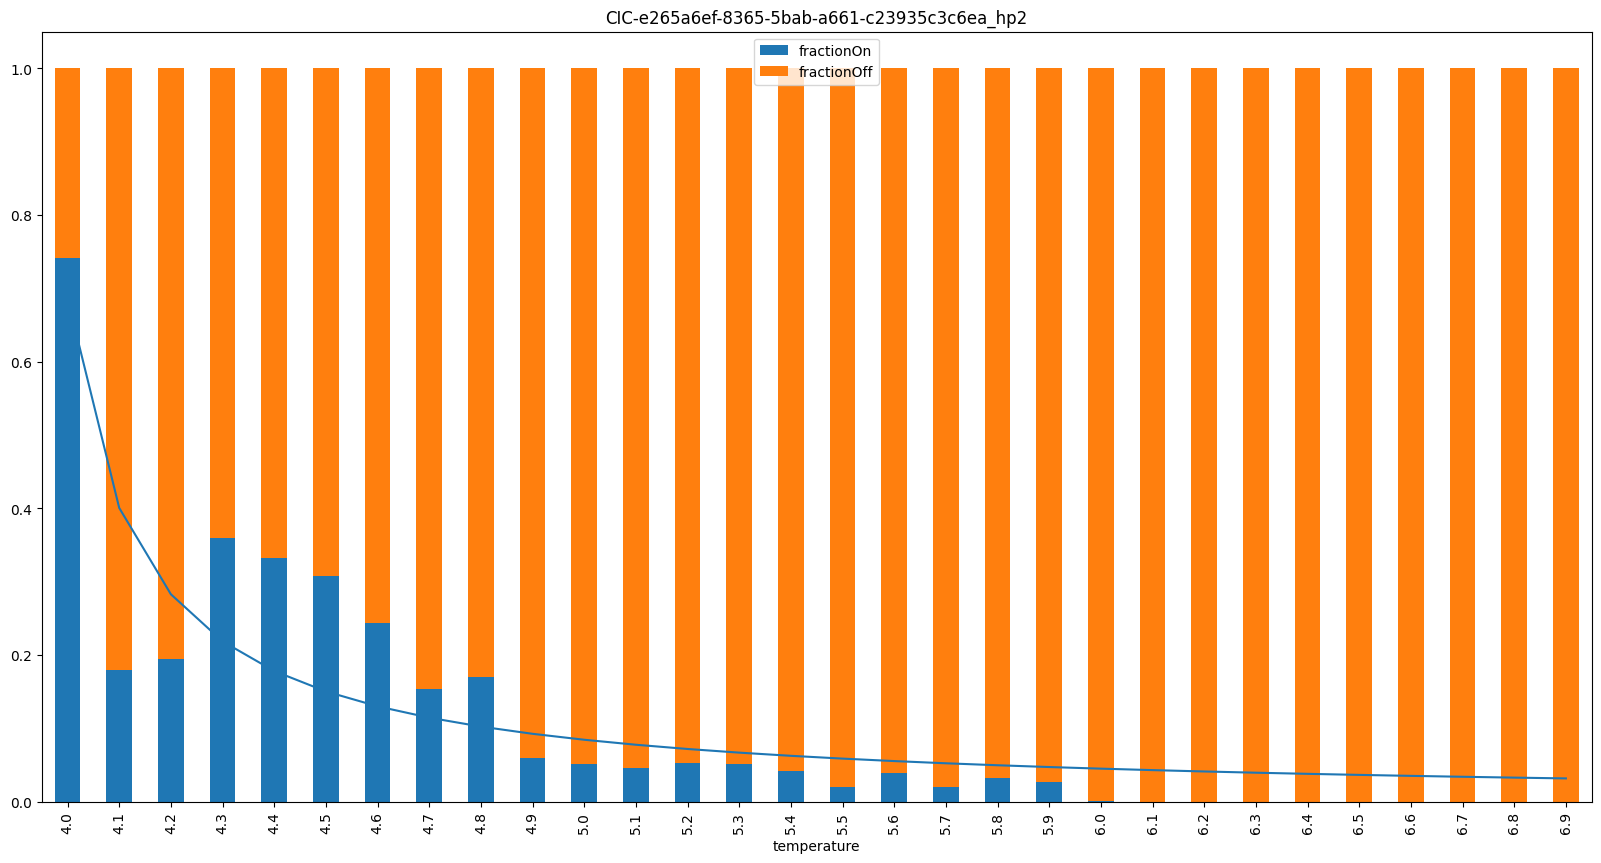

In [ ]:
# comparison of bar plots for each seperate cic
energyX_train = energy_train.join(X_train)
for cic in energyX_train['system.quattId'].unique():
    heatcoil_df = pd.DataFrame(temperatures, columns=['temperature'])

    heatcoil_df['countHeatCoilOn'] = heatcoil_df['temperature'].apply(lambda x: len(energyX_train[(energyX_train['qc.hp1PowerInput']>0) &
                                                                                            (energyX_train['hp1.temperatureOutsideRounded'] == x) &
                                                                                            (energyX_train['hp1.bottomPlateHeaterEnable'] == 1) &
                                                                                            (energyX_train['system.quattId'] == cic)]))
    heatcoil_df['countHeatCoilOff'] = heatcoil_df['temperature'].apply(lambda x: len(energyX_train[(energyX_train['qc.hp1PowerInput']>0) &
                                                                                            (energyX_train['hp1.temperatureOutsideRounded'] == x) &
                                                                                            (energyX_train['hp1.bottomPlateHeaterEnable'] == 0) &
                                                                                            (energyX_train['system.quattId'] == cic)]))
    heatcoil_df['fractionOn'] = heatcoil_df['countHeatCoilOn'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])
    heatcoil_df['fractionOff'] = heatcoil_df['countHeatCoilOff'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])

    # set temperature values as index
    heatcoil_df.set_index('temperature', inplace=True)

    def func(x, a, b, c):
        return 1 / (a + b*(x-c))
    popt, pcov = curve_fit(func, heatcoil_df.index, heatcoil_df['fractionOn'])
    print(popt)

    # create absolute and relative stacked bar plots
    ax2 = heatcoil_df[['fractionOn', 'fractionOff']].plot.bar(stacked=True, figsize=[20,10])
    ax2.plot(10*(heatcoil_df.index-4), (1/(popt[0] + popt[1]*(heatcoil_df.index-popt[2]))).tolist())
    plt.title(cic)
    # ax2.plot(heatcoil_df.index.tolist(), (1/(1.11 + 4.63*(heatcoil_df.index-4))).tolist())
    plt.show()